In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113655 sha256=7b5046c0553ec5d7d626118b9df91b282ee649abebe2f322114dbd529b5f2246
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from pycatch22 import catch22_all
from scipy.signal import resample
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings("ignore")

# === Load ECG & EEG ===
with open("/content/drive/MyDrive/output_ecg_data/processed_ecg_data.pkl", "rb") as f:
    ecg_data = pickle.load(f)["data"]

with open("/content/drive/MyDrive/output_eeg_data/processed_eeg_data.pkl", "rb") as f:
    eeg_data = pickle.load(f)["data"]

In [ ]:
# === Preprocessing ===
def clean_and_downsample(data, target_len=2000):
    def clean(x): return (np.nan_to_num(x) - np.nanmean(x)) / (np.nanstd(x) + 1e-8)
    return np.array([resample(clean(sig), target_len) for sig in data])

def extract_catch22(X):
    return np.array([catch22_all(sig)["values"] for sig in tqdm(X)])

# === Labels ===
label_map_mem = {"Five": 0, "Nine": 1, "Thirteen": 2}
label_map_4class = {"JustListen": 0, "Five": 1, "Nine": 2, "Thirteen": 3}

# === Dataset Generation ===
def prepare_dataset(data, mode):
    X, y = [], []
    for subj in data:
        for cond_idx, cond in enumerate(["Five", "Nine", "Thirteen"]):
            for trial_idx in range(54):
                if mode == "memory":
                    for subcond in [1, 2]:
                        sig = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig).all():
                            X.append(sig)
                            y.append(label_map_mem[cond])
                elif mode == "binary":
                    sig_jl = subj[cond_idx, 0, trial_idx]
                    if not np.isnan(sig_jl).all():
                        X.append(sig_jl)
                        y.append(0)
                    for subcond in [1, 2]:
                        sig_mem = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig_mem).all():
                            X.append(sig_mem)
                            y.append(1)
                elif mode == "4class":
                    sig_jl = subj[cond_idx, 0, trial_idx]
                    if not np.isnan(sig_jl).all():
                        X.append(sig_jl)
                        y.append(0)
                    for subcond in [1, 2]:
                        sig_mem = subj[cond_idx, subcond, trial_idx]
                        if not np.isnan(sig_mem).all():
                            y_val = label_map_4class[["Five", "Nine", "Thirteen"][cond_idx]]
                            X.append(sig_mem)
                            y.append(y_val)
    return np.array(X), np.array(y)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        objective="multi:softprob", random_state=42, n_jobs=-1
    ),
}

# === Fusion Trainer ===
def train_fusion_classifier(X_train, y_train, X_test, y_test, labels, task_name):
    print(f"\n📚 Task: {task_name}")
    print("🔢 ECG Train Class Distribution:", Counter(y_train))
    print("🔢 EEG Test Class Distribution:", Counter(y_test))

    X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

    for name, model in models.items():
        print(f"\n📊 Model: {name}")
        num_classes = len(np.unique(y_train))
        if name == "XGBoost":
            if num_classes > 2:
                model.set_params(objective="multi:softprob", num_class=num_classes)
            else:
                model.set_params(objective="binary:logistic")

        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)
        y_pred = np.argmax(probs, axis=1) if probs.shape[1] > 2 else (probs[:, 1] > 0.5).astype(int)

        print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
        print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Confusion Matrix Plot
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
                    cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"{name} - Confusion Matrix ({task_name})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        # ROC Curve Plot
        if probs.shape[1] == 2:  # binary
            fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{name} - ROC Curve ({task_name})")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:  # multiclass
            for i, label in enumerate(labels):
                fpr, tpr, _ = roc_curve((y_test == i).astype(int), probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{name} - ROC Curve ({task_name})")
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Feature Importance
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            top_idx = np.argsort(importances)[::-1][:10]
            plt.figure(figsize=(8, 4))
            plt.bar(range(10), importances[top_idx], color='orange')
            plt.xticks(range(10), [f"F{i}" for i in top_idx], rotation=45)
            plt.title(f"{name} - Top 10 Important Features ({task_name})")
            plt.tight_layout()
            plt.show()

In [ ]:
def run_fusion(mode, label_names):
    assert mode in ["binary", "memory", "4class"], f"Invalid mode: {mode}"
    print(f"\n🧪 Running Fusion Mode: {mode.upper()}")

    # === Load + Clean + Balance ===
    X_ecg, y_ecg = prepare_dataset(ecg_data, mode=mode)
    X_ecg = clean_and_downsample(X_ecg)

    print("⚖️ Balancing ECG Training Data...")
    X_ecg, y_ecg = RandomOverSampler(random_state=42).fit_resample(X_ecg, y_ecg)
    print("🔁 Balanced Class Distribution:", Counter(y_ecg))

    X_ecg_features = extract_catch22(X_ecg)

    X_eeg, y_eeg = prepare_dataset(eeg_data, mode=mode)
    X_eeg = clean_and_downsample(X_eeg)

    print("⚖️ Balancing EEG Testing Data...")
    X_eeg, y_eeg = RandomOverSampler(random_state=42).fit_resample(X_eeg, y_eeg)
    print("🔁 Balanced Class Distribution:", Counter(y_eeg))

    X_eeg_features = extract_catch22(X_eeg)

    train_fusion_classifier(X_ecg_features, y_ecg, X_eeg_features, y_eeg, labels=label_names, task_name=mode)


🧪 Running Fusion Mode: MEMORY
⚖️ Balancing ECG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 2395, np.int64(1): 2395, np.int64(2): 2395})


100%|██████████| 6660/6660 [02:10<00:00, 51.14it/s]



📚 Task: memory
🔢 ECG Train Class Distribution: Counter({np.int64(0): 2395, np.int64(1): 2395, np.int64(2): 2395})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 2360, np.int64(1): 2239, np.int64(2): 2061})

📊 Model: Random Forest
✅ Accuracy: 0.9958
✅ Classification Report:
               precision    recall  f1-score   support

        Five       1.00      1.00      1.00      2360
        Nine       1.00      0.99      0.99      2239
    Thirteen       0.99      1.00      0.99      2061

    accuracy                           1.00      6660
   macro avg       1.00      1.00      1.00      6660
weighted avg       1.00      1.00      1.00      6660

✅ Confusion Matrix:
 [[2353    2    5]
 [   0 2220   19]
 [   0    2 2059]]


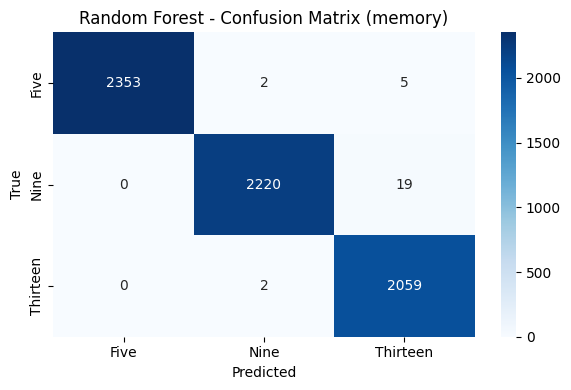

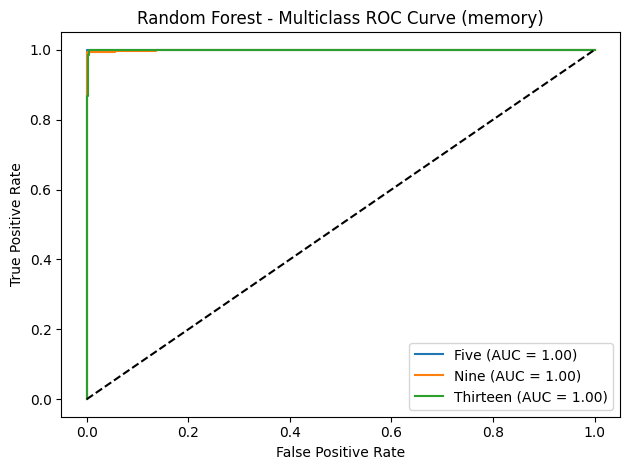

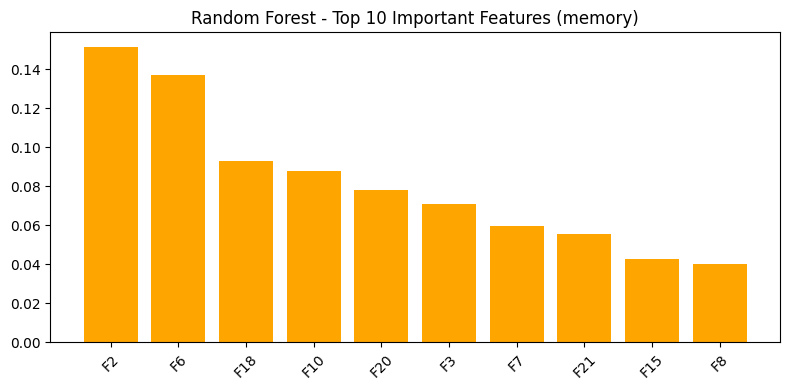


📊 Model: SVM
✅ Accuracy: 0.9026
✅ Classification Report:
               precision    recall  f1-score   support

        Five       0.95      0.99      0.97      2360
        Nine       0.82      0.99      0.90      2239
    Thirteen       0.98      0.70      0.82      2061

    accuracy                           0.90      6660
   macro avg       0.92      0.90      0.90      6660
weighted avg       0.91      0.90      0.90      6660

✅ Confusion Matrix:
 [[2348    8    4]
 [   1 2216   22]
 [ 130  484 1447]]


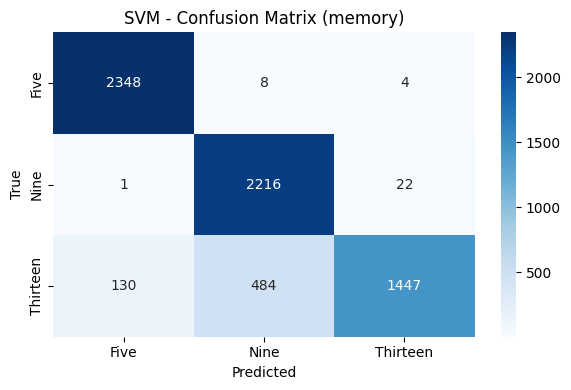

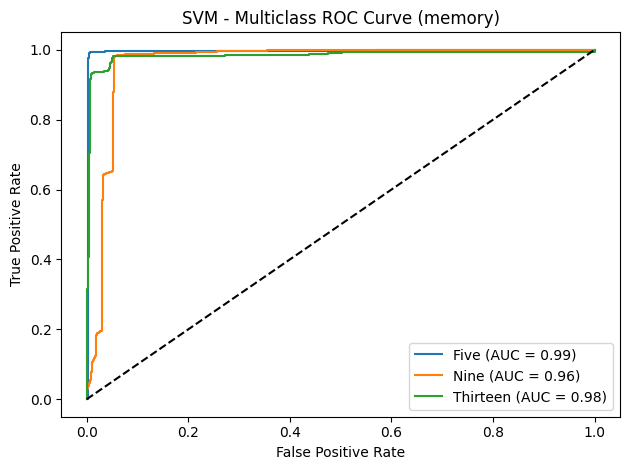


📊 Model: XGBoost
✅ Accuracy: 0.9962
✅ Classification Report:
               precision    recall  f1-score   support

        Five       1.00      1.00      1.00      2360
        Nine       1.00      0.99      1.00      2239
    Thirteen       0.99      1.00      0.99      2061

    accuracy                           1.00      6660
   macro avg       1.00      1.00      1.00      6660
weighted avg       1.00      1.00      1.00      6660

✅ Confusion Matrix:
 [[2353    4    3]
 [   0 2222   17]
 [   0    1 2060]]


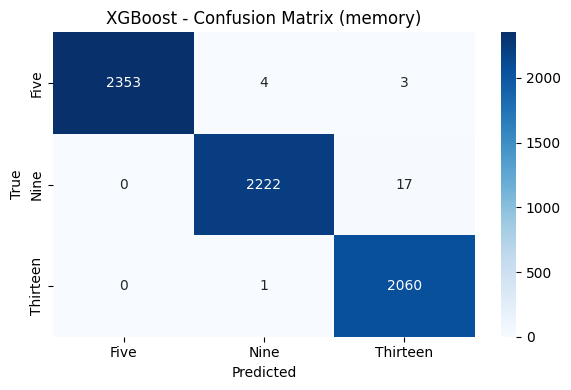

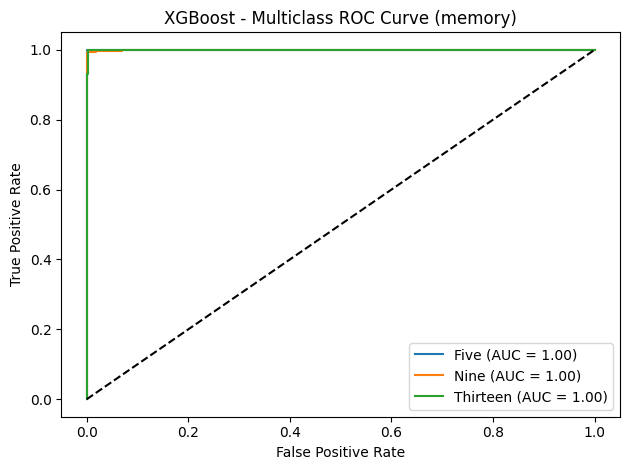

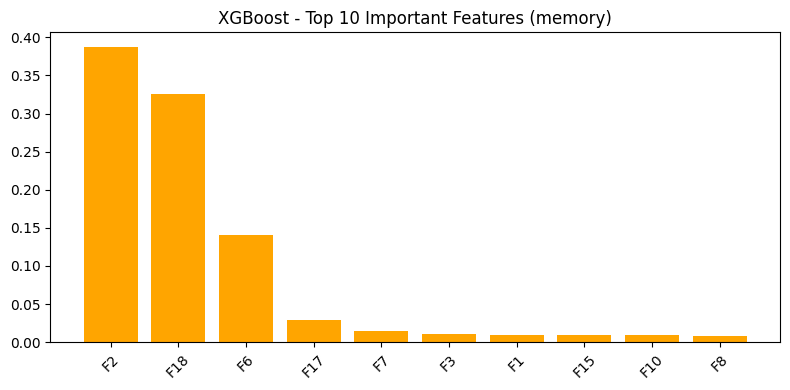

In [ ]:
# === Run All Tasks ===
run_fusion("memory", label_names=["Five", "Nine", "Thirteen"])


🧪 Running Fusion Mode: BINARY
⚖️ Balancing ECG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 6990, np.int64(1): 6990})


100%|██████████| 13980/13980 [04:28<00:00, 52.06it/s]


⚖️ Balancing EEG Testing Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 6660, np.int64(1): 6660})


100%|██████████| 13320/13320 [04:10<00:00, 53.19it/s]



📚 Task: binary
🔢 ECG Train Class Distribution: Counter({np.int64(0): 6990, np.int64(1): 6990})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 6660, np.int64(1): 6660})

📊 Model: Random Forest
✅ Accuracy: 0.4999
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.50      0.07      0.12      6660
      Memory       0.50      0.93      0.65      6660

    accuracy                           0.50     13320
   macro avg       0.50      0.50      0.38     13320
weighted avg       0.50      0.50      0.38     13320

✅ Confusion Matrix:
 [[ 434 6226]
 [ 435 6225]]


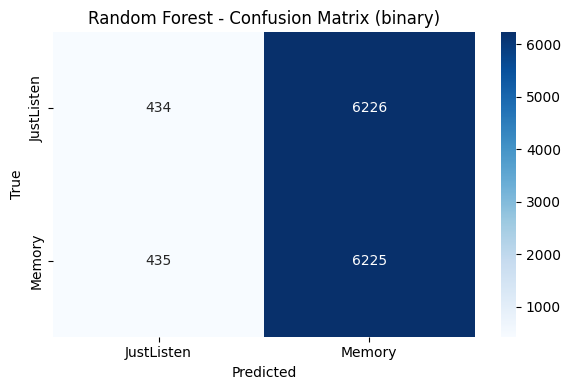

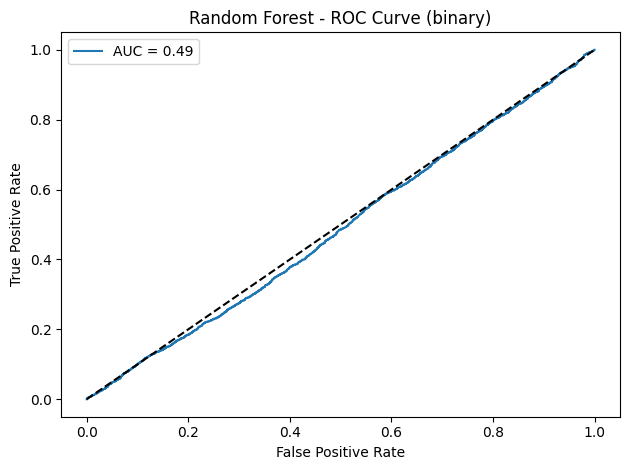

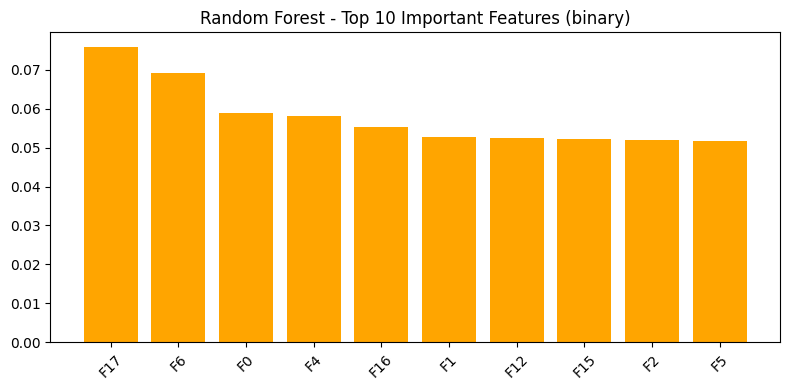


📊 Model: SVM
✅ Accuracy: 0.4958
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.50      0.84      0.63      6660
      Memory       0.49      0.15      0.23      6660

    accuracy                           0.50     13320
   macro avg       0.49      0.50      0.43     13320
weighted avg       0.49      0.50      0.43     13320

✅ Confusion Matrix:
 [[5599 1061]
 [5655 1005]]


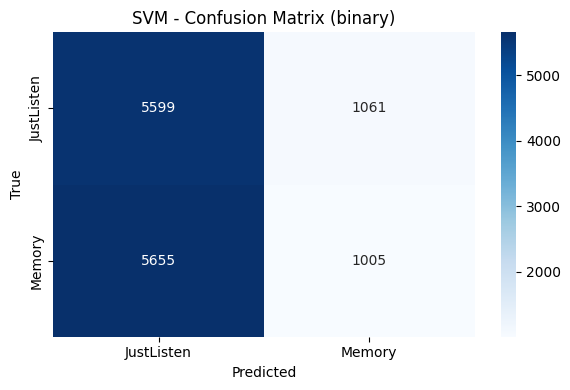

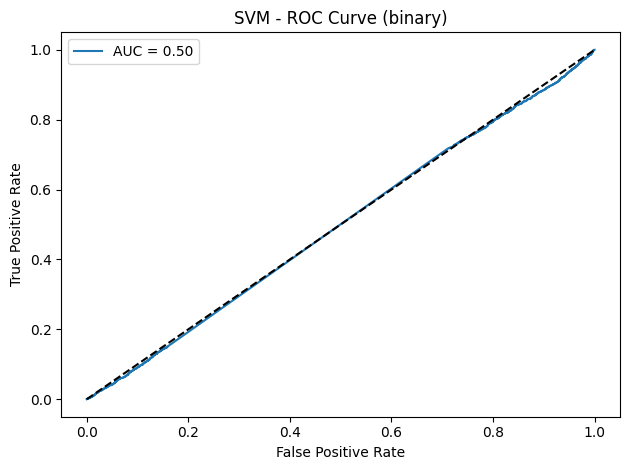


📊 Model: XGBoost
✅ Accuracy: 0.5034
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.51      0.16      0.24      6660
      Memory       0.50      0.85      0.63      6660

    accuracy                           0.50     13320
   macro avg       0.51      0.50      0.44     13320
weighted avg       0.51      0.50      0.44     13320

✅ Confusion Matrix:
 [[1049 5611]
 [1004 5656]]


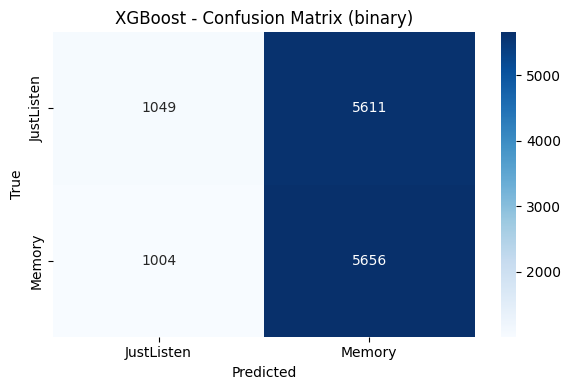

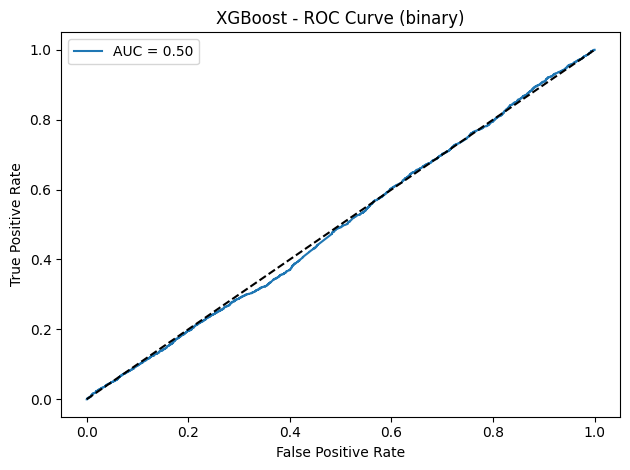

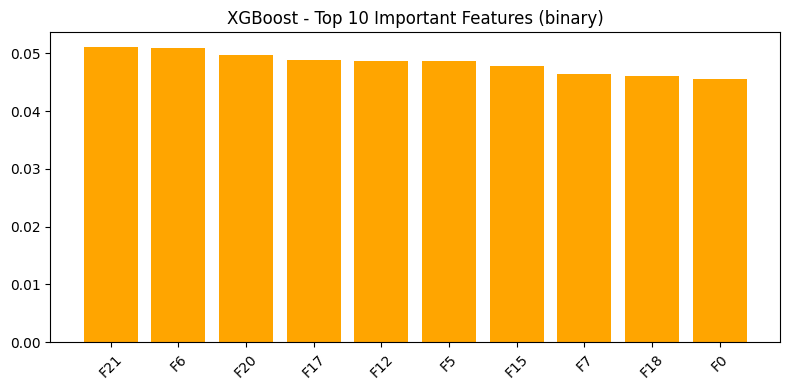

In [ ]:
run_fusion("binary", label_names=["JustListen", "Memory"])


🧪 Running Fusion Mode: 4CLASS
⚖️ Balancing ECG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 3251, np.int64(1): 3251, np.int64(2): 3251, np.int64(3): 3251})


100%|██████████| 13004/13004 [04:14<00:00, 51.18it/s]


⚖️ Balancing ECG Training Data...
🔁 Balanced Class Distribution: Counter({np.int64(0): 3077, np.int64(1): 3077, np.int64(2): 3077, np.int64(3): 3077})


100%|██████████| 12308/12308 [03:56<00:00, 52.02it/s]



📚 Task: 4class
🔢 ECG Train Class Distribution: Counter({np.int64(0): 3251, np.int64(1): 3251, np.int64(2): 3251, np.int64(3): 3251})
🔢 EEG Test Class Distribution: Counter({np.int64(0): 3077, np.int64(1): 3077, np.int64(2): 3077, np.int64(3): 3077})

📊 Model: Random Forest
✅ Accuracy: 0.7463
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.26      0.00      0.00      3077
        Five       0.74      1.00      0.85      3077
        Nine       0.74      0.99      0.85      3077
    Thirteen       0.75      1.00      0.86      3077

    accuracy                           0.75     12308
   macro avg       0.63      0.75      0.64     12308
weighted avg       0.63      0.75      0.64     12308

✅ Confusion Matrix:
 [[   5 1050 1041  981]
 [   4 3064    2    7]
 [   1    0 3050   26]
 [   9    0    2 3066]]


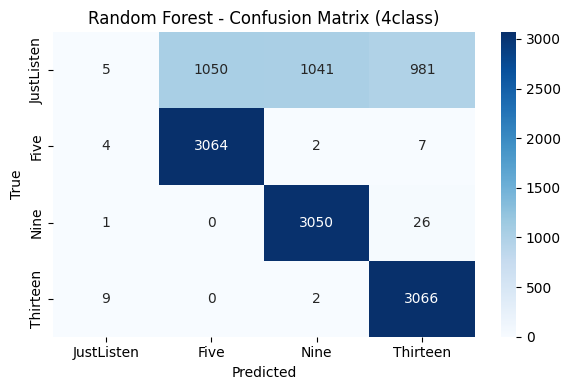

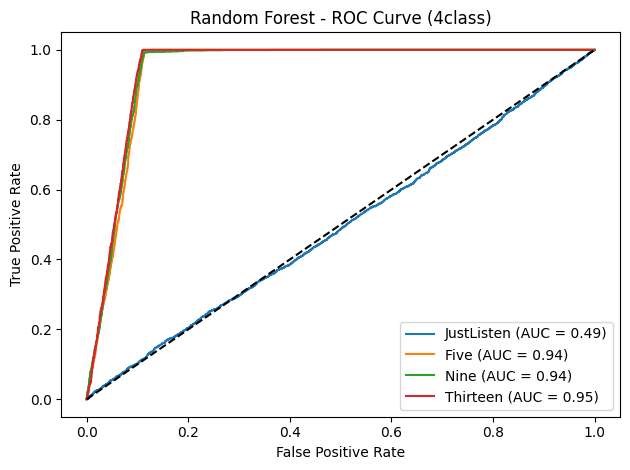

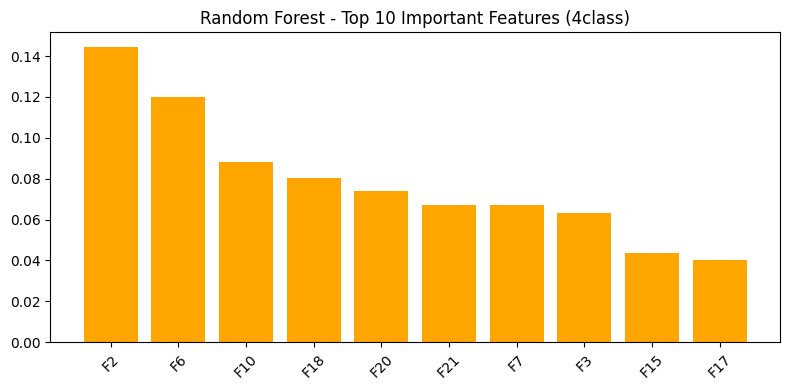


📊 Model: SVM
✅ Accuracy: 0.6594
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.24      0.03      0.06      3077
        Five       0.72      0.99      0.84      3077
        Nine       0.60      0.99      0.74      3077
    Thirteen       0.75      0.62      0.68      3077

    accuracy                           0.66     12308
   macro avg       0.58      0.66      0.58     12308
weighted avg       0.58      0.66      0.58     12308

✅ Confusion Matrix:
 [[  97 1081 1306  593]
 [   1 3061    9    6]
 [   6    1 3038   32]
 [ 301  109  747 1920]]


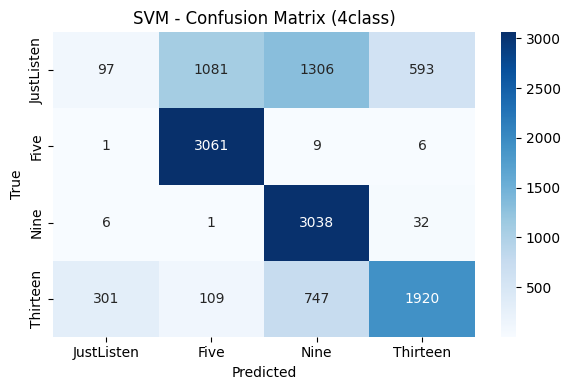

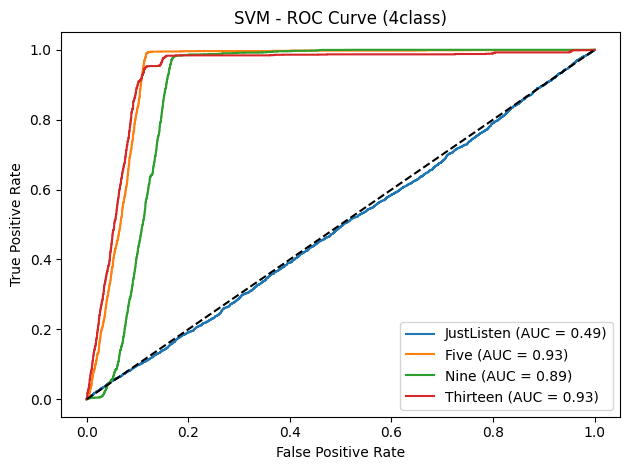


📊 Model: XGBoost
✅ Accuracy: 0.7368
✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.28      0.03      0.05      3077
        Five       0.74      0.99      0.85      3077
        Nine       0.75      0.95      0.84      3077
    Thirteen       0.75      0.98      0.85      3077

    accuracy                           0.74     12308
   macro avg       0.63      0.74      0.65     12308
weighted avg       0.63      0.74      0.65     12308

✅ Confusion Matrix:
 [[  84 1047  993  953]
 [  25 3051    1    0]
 [ 119    0 2929   29]
 [  72    0    0 3005]]


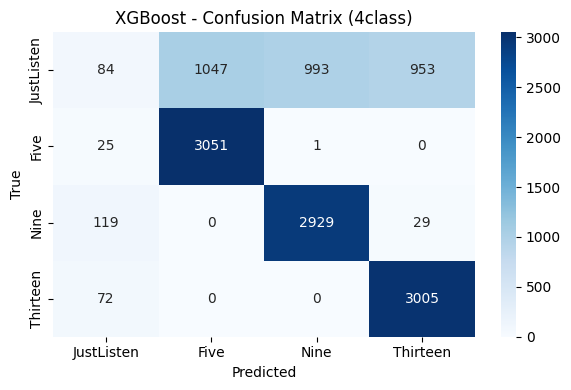

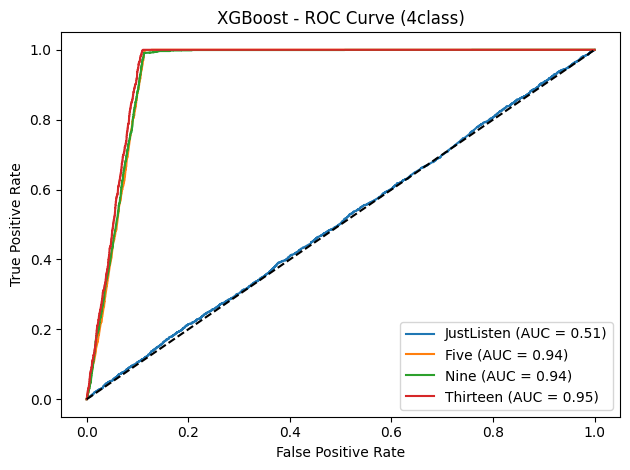

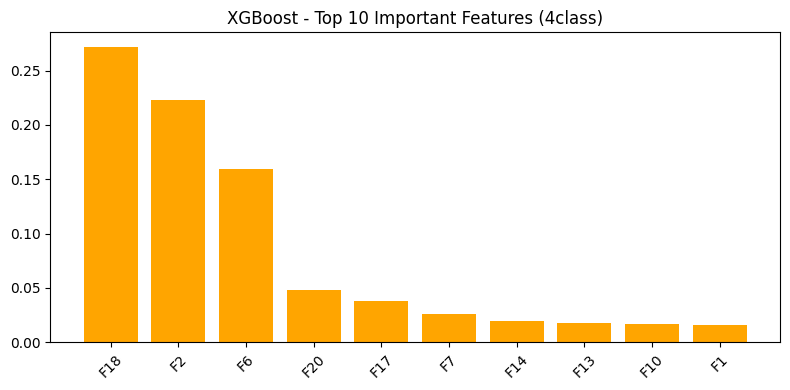

In [ ]:
run_fusion("4class", label_names=["JustListen", "Five", "Nine", "Thirteen"])